# **Implementación y análisis de modelos de difusión**

Germán José Padua Pleguezuelo

Álvaro Luna Ramírez

Pedro Jiménez García-Ligero


En este cuaderno implementamos una modificación al modelo básico. En este caso, para mejorar el entrenamiento hemos decidido reducir el learning rate cada 25 épocas.

# **Preparación básica**

## **Configuración inicial**
En esta primera sección, importaremos las librerías necesarias. Además, descargaremos y organizaremos las imágenes con las que vamos a trabajar.

### **Librerías e instalación de paquetes**

In [ ]:
!pip install fastparquet
!pip install pytorch-ignite
!pip install torchinfo

import os
import json
import shutil

import pandas as pd
import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

from torchinfo import summary

from sklearn.model_selection import train_test_split

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import PIL.Image as Image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.4/272.4 kB 4.5 MB/s eta 0:00:00


### **Dataset**

En primer lugar, descargamos el dataset y creamos carpetas para guardar las imágenes.

In [ ]:
# Seleccionamos el dipositivo disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Para descargar datasets configuramos la API de Kaggle
%mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

#api_token = {"username":"kripxera","key":"e17dd1dfc853c0bc94b6038413a23774"}
api_token = {"username":"germanpadua","key":"9a9b82fdb0185268db1392abf661caf9"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Acceso root para el json
!chmod 600 ~/.kaggle/kaggle.json

# Descargamos el dataset de 'Standford cars' y creamos una carpeta con todos los datos
# Combinamos test y entrenamiento para separarlo manualmente
!kaggle datasets download -d jessicali9530/stanford-cars-dataset
!unzip /content/stanford-cars-dataset.zip -d /content/stanford-cars-dataset
%mkdir -p /content/cars/data
!find /content/stanford-cars-dataset -type f -name "*.jpg" -exec mv {} /content/cars/data \;

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03145.jpg  
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03146.jpg  
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03147.jpg  
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03148.jpg  
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03149.jpg  
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03150.jpg  
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03151.jpg  
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03152.jpg  
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03153.jpg  
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03154.jpg  
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03155.jpg  
  inflating: /content/stanford-cars-dataset/cars_train/cars_train/03156.jpg  
  i

In [ ]:
def list_images(base_directory):
    images = []
    images_directory = os.path.join(base_directory, 'data')

    for image in os.listdir(images_directory):
        if image.endswith('.jpg'):
            images.append(os.path.join(images_directory, image))

    return images

In [ ]:
# Cogemos el dataset
dataset_path = '/content/cars'

In [ ]:
# Separamos manualmente en entrenamiento y test

images = list_images(dataset_path)
images_train, images_test = train_test_split(images,test_size=0.2, random_state=42)

In [ ]:
def  move_images(images, destination_directory):
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    for image in images:
        shutil.move(image, destination_directory)

# Separamos las imágenes en sus respectivas carpetas
move_images(images_train, dataset_path+'/train/all')
move_images(images_test, dataset_path+'/test/all')

A continuación establecemos el tamaño del batch a 64. Hemos decidido este tamaño para encontrar un equilibrio entre tiempo de entrenamiento y la calidad de las imágenes generadas.

Realizamos una serie de transformaciones a las imágenes que vamos a usar. En primer lugar las redimensionamos, ya que vamos a trabajar con imágenes de tamaño 32x32. A continuación las convertimos en tensores y normalizamos.

In [ ]:
batch_size = 32
height = 32
width = 32

transform = transforms.Compose([
    transforms.Resize((height, width)),  # Redimensionar la imagen primero
    transforms.ToTensor(),  # Luego convertir la imagen PIL a un Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalizar el tensor. Esto suele ayudar a estabilizar y acelerar el entrenamiento de modelos.
])

In [ ]:
# Train dataloader
train_cars = ImageFolder(dataset_path+'/train', transform=transform)
train_loader = DataLoader(train_cars, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

# Test dataloader
test_cars = ImageFolder(dataset_path+'/test', transform=transform)
test_loader = DataLoader(test_cars, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

Mostramos un ejemplo con imágenes del dataset.

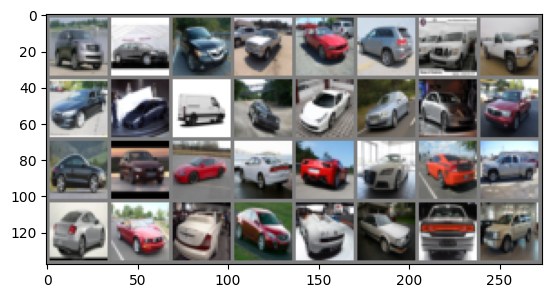

In [ ]:
# Función para mostrar las imágenes
def imshow(img):
    npimg = img.numpy()
    npimg = (npimg - npimg.min()) / (npimg.max() - npimg.min()) #Normalizamos para una visualización correcta
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtener un batch de imágenes de entrenamiento
dataiter = iter(train_loader)
images, _ = next(dataiter) # No usamos las etiquetas porque no hay categorías

# Mostrar imágenes
imshow(torchvision.utils.make_grid(images))

In [ ]:
#Creamos otras funciones de visualización de imágenes que se utilizarán más adelante
def cvtImg(img):
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

#x, _ = next(iter(train_loader))
#show_examples(x)

## **Modelo de Difusión**

### **Arquitectura**



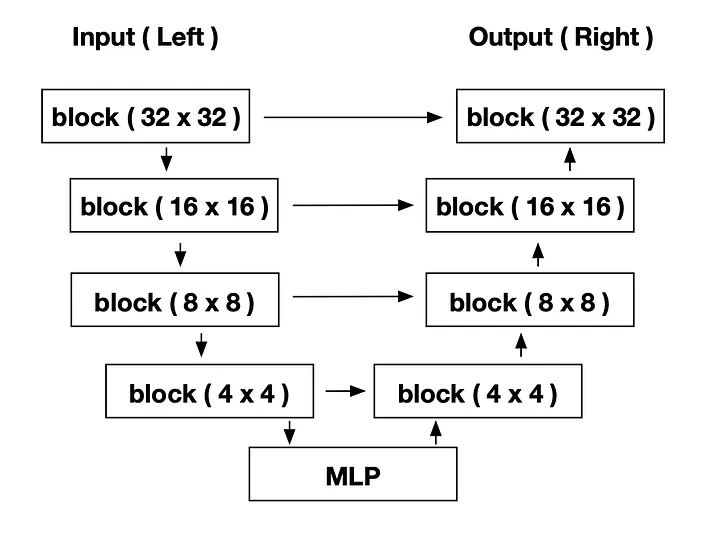

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()

        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )

        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)

        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),

            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )

        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)

        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)

        # Optimizador
        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)

    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts)

        # ----- Down -----
        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)

        # ----- MLP -----
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)

        # ----- Up -----
        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]

        for i, block in enumerate(blocks):
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)

            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')

        # ----- Output -----
        x = self.cnn_output(x) # Collapse all depth dimensions into rgb

        return x

model = Model().to(device)
print(model)

Model(
  (l_ts): Sequential(
    (0): Linear(in_features=1, out_features=192, bias=True)
    (1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (down_x32): Block(
    (conv_param): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dense_ts): Linear(in_features=192, out_features=128, bias=True)
    (layer_norm): LayerNorm((128, 32, 32), eps=1e-05, elementwise_affine=True)
  )
  (down_x16): Block(
    (conv_param): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dense_ts): Linear(in_features=192, out_features=128, bias=True)
    (layer_norm): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
  )
  (down_x8): Block(
    (conv_param): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(128, 128, kernel_

In [ ]:
# Mostramos información de nuestro modelo usando sample inputs

# Sample inputs
x_input = torch.randn(1, 3, 32, 32).to(device)
y_input = torch.randn(1, 1).to(device)

# Usamos 'summary' de torchinfo
summary(model, input_data=(x_input, y_input))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 3, 32, 32]            --
├─Sequential: 1-1                        [1, 192]                  --
│    └─Linear: 2-1                       [1, 192]                  384
│    └─LayerNorm: 2-2                    [1, 192]                  384
│    └─ReLU: 2-3                         [1, 192]                  --
├─Block: 1-2                             [1, 128, 32, 32]          --
│    └─Conv2d: 2-4                       [1, 128, 32, 32]          3,584
│    └─Linear: 2-5                       [1, 128]                  24,704
│    └─Conv2d: 2-6                       [1, 128, 32, 32]          3,584
│    └─LayerNorm: 2-7                    [1, 128, 32, 32]          262,144
├─Block: 1-3                             [1, 128, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 128, 16, 16]          147,584
│    └─Linear: 2-9                       [1, 128]              

### **Forward noise**


Aquí establecemos el valor de "timesteps" a 16. De esta manera, nuestro modelo aprenderá a producir imágenes desde ruidosas (nivel 0) a claras (nivel 16) durante el proceso de entrenamiento.

En la gráfica que mostraremos a continuación, podemos ver que desde el timestep 0 hasta el 16, se va reduciendo el ruido y la claridad mejora progresivamente.

In [ ]:
# Set noise scheduler
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

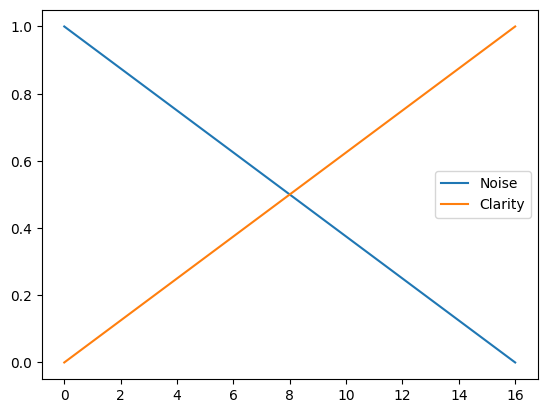

In [ ]:
plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.legend()

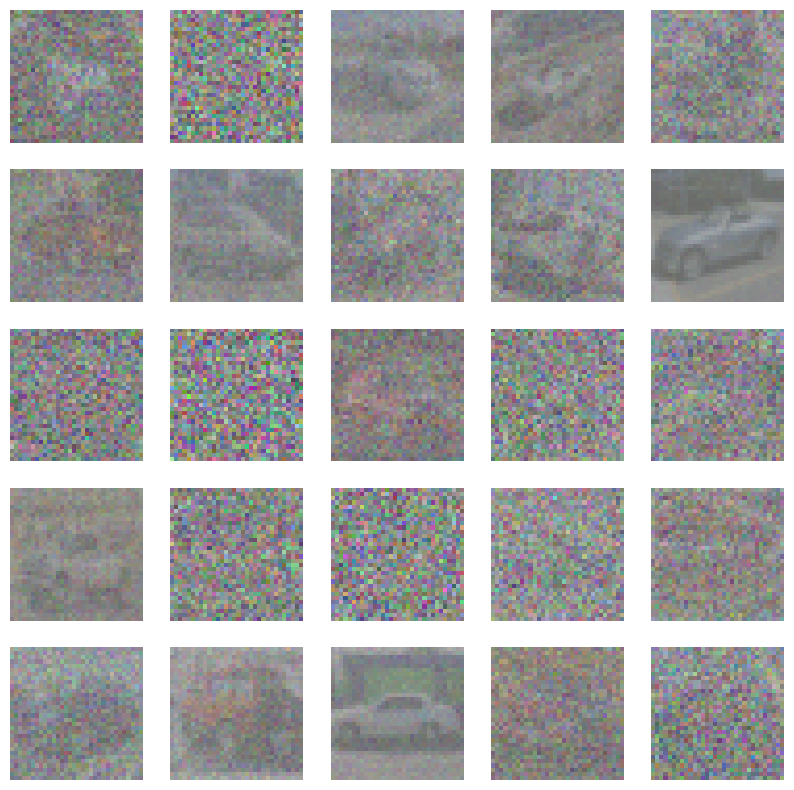

In [ ]:
# Avanzar un paso: añade ruido
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1

    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b


# Generamos num enteros con valores entre 0 y timesteps.
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # Generate time steps to with
x, _ = next(iter(train_loader))
a, b = forward_noise(x[:25], t)
show_examples(b)    #Vemos algunos ejemplos de imágenes en distintos pasos de ruido

### **Predicción**

En este apartado definiremos los métodos que utilizaremos para generar imágenes con nustro modelo.

De esta forma, podremos ver su rendimiento.

  0%|          | 0/16 [00:00<?, ?it/s]

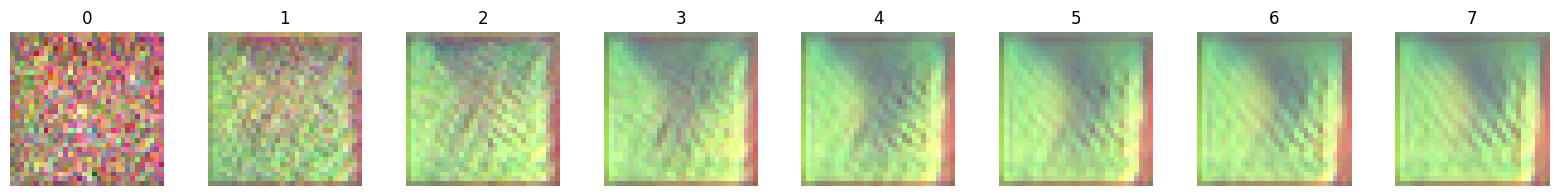

In [ ]:
# Toma un ruido aleatorio y predice una imagen realizando todos los pasos (denoising)
def predict_step():
    xs = []
    # Ruido inicial aleatorio
    x = torch.randn(size=(1, 3, height, width), device=device)

    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            # Usamos el modelo para predecir la imagen que se usará en el siguiente paso (quitamos ruido a la imagen)
            x = model(x, torch.full([1, 1], t, dtype=torch.float, device=device))

            # Mostramos los resultados cada dos pasos para apreciar más diferencias
            if i % 2 == 0:
                xs.append(x[0].cpu())

    # Visualización
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = cvtImg(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

# Vemos un ejemplo de uso del método
predict_step()

# Creamos una versión del método en la que se parte de una imagen pasada
# como parámetro en lugar de crear un ruido aleatorio al inicio
def predict_step_fixed(x_fixed):
    xs = []
    x = x_fixed

    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            # Usamos el modelo para predecir la imagen que se usará en el siguiente paso (quitamos ruido a la imagen)
            x = model(x, torch.full([1, 1], t, dtype=torch.float, device=device))

            # Mostramos los resultados cada dos pasos para apreciar más diferencias
            if i % 2 == 0:
                xs.append(x[0].cpu())

    # Visualización
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = cvtImg(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')


  0%|          | 0/16 [00:00<?, ?it/s]

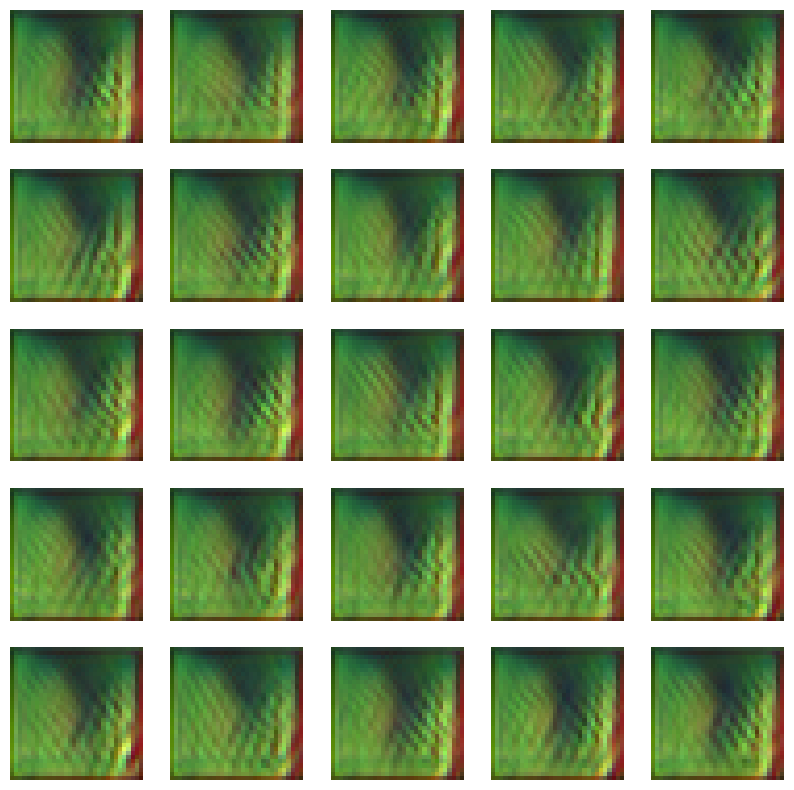

In [ ]:
# Usamos el modelo en 25 imágenes aleatorias (de ruido), mostrando solo el resultado final
def predict(x_idx=None):
    # Creamos 25 imágenes aleatorias (ruido)
    x = torch.randn(25, 3, height, width).to(device)
    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            # Usamos el modelo para predecir la imagen que se usará en el siguiente paso (quitamos ruido a la imagen)
            x = model(x, torch.full([25, 1], t, dtype=torch.float, device=device))

    # Mostramos el resultado final (sin ruido) que ha producido el modelo de las 25 imágenes iniciales
    show_examples(x.cpu())

# Vemos un ejemplo de uso del método
predict()

# Creamos una versión del método en la que se parte de 25 imágenes pasadas
# como parámetro en lugar de crear ruido aleatorio al inicio
def predict_fixed(x_fixed):
    x = x_fixed
    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            # Usamos el modelo para predecir la imagen que se usará en el siguiente paso (quitamos ruido a la imagen)
            x = model(x, torch.full([25, 1], t, dtype=torch.float, device=device))

    # Mostramos el resultado final (sin ruido) que ha producido el modelo de las 25 imágenes iniciales
    show_examples(x.cpu())

## **Métricas de entrenamiento**

En esta sección definiremos la métrica FID.

In [ ]:
# Genera imágenes sin ruido para el FID
def sample(initial_noise):
    with torch.no_grad():
        for i in range(timesteps):
            t = i
            initial_noise = model(initial_noise, torch.full([len(initial_noise), 1], t, dtype=torch.float, device=device))

        # Normalización min-max
        min_val = initial_noise.min()
        max_val = initial_noise.max()
        normalized_noise = (initial_noise - min_val) / (max_val - min_val)

    return normalized_noise.cpu()  # Devuelve el tensor normalizado de las imágenes generadas


In [ ]:
# Code obtained from: https://github.com/hukkelas/pytorch-frechet-inception-distance/blob/master/fid.py
import torch
from torch import nn
from torchvision.models import inception_v3
import cv2
import multiprocessing
import numpy as np
import glob
import os
from scipy import linalg
import warnings

def to_cuda(elements):
    """
    Transfers elements to cuda if GPU is available
    Args:
        elements: torch.tensor or torch.nn.module
        --
    Returns:
        elements: same as input on GPU memory, if available
    """
    if torch.cuda.is_available():
        return elements.cuda()
    return elements


class PartialInceptionNetwork(nn.Module):
    def __init__(self, transform_input=True):
        super().__init__()
        self.inception_network = inception_v3(pretrained=True)
        self.inception_network.Mixed_7c.register_forward_hook(self.output_hook)
        self.transform_input = transform_input

    def output_hook(self, module, input, output):
        # N x 2048 x 8 x 8
        self.mixed_7c_output = output

    def forward(self, x):
        """
        Args:
            x: shape (N, 3, 299, 299) dtype: torch.float32 in range 0-1
        Returns:
            inception activations: torch.tensor, shape: (N, 2048), dtype: torch.float32
        """
        assert x.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                             ", but got {}".format(x.shape)
        x = x * 2 -1 # Normalize to [-1, 1]

        # Trigger output hook
        self.inception_network(x)

        # Output: N x 2048 x 1 x 1
        activations = self.mixed_7c_output
        activations = torch.nn.functional.adaptive_avg_pool2d(activations, (1,1))
        activations = activations.view(x.shape[0], 2048)
        return activations


def get_activations(images, batch_size):
    """
    Calculates activations for last pool layer for all iamges
    --
        Images: torch.array shape: (N, 3, 299, 299), dtype: torch.float32
        batch size: batch size used for inception network
    --
    Returns: np array shape: (N, 2048), dtype: np.float32
    """
    assert images.shape[1:] == (3, 299, 299), "Expected input shape to be: (N,3,299,299)" +\
                                              ", but got {}".format(images.shape)

    num_images = images.shape[0]
    inception_network = PartialInceptionNetwork()
    inception_network = to_cuda(inception_network)
    inception_network.eval()
    n_batches = int(np.ceil(num_images  / batch_size))
    inception_activations = np.zeros((num_images, 2048), dtype=np.float32)
    for batch_idx in range(n_batches):
        start_idx = batch_size * batch_idx
        end_idx = batch_size * (batch_idx + 1)

        ims = images[start_idx:end_idx]
        ims = to_cuda(ims)
        activations = inception_network(ims)
        activations = activations.detach().cpu().numpy()
        assert activations.shape == (ims.shape[0], 2048), "Expexted output shape to be: {}, but was: {}".format((ims.shape[0], 2048), activations.shape)
        inception_activations[start_idx:end_idx, :] = activations
    return inception_activations



def calculate_activation_statistics(images, batch_size):
    """Calculates the statistics used by FID
    Args:
        images: torch.tensor, shape: (N, 3, H, W), dtype: torch.float32 in range 0 - 1
        batch_size: batch size to use to calculate inception scores
    Returns:
        mu:     mean over all activations from the last pool layer of the inception model
        sigma:  covariance matrix over all activations from the last pool layer
                of the inception model.

    """
    act = get_activations(images, batch_size)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


# Modified from: https://github.com/bioinf-jku/TTUR/blob/master/fid.py
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance. ... [resto de la documentación] ... """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # Añadiendo un pequeño valor a la diagonal de las matrices de covarianza
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean


def preprocess_images(images):
    """ Normaliza las imágenes para que estén en el rango de 0 a 1.
    Args:
        images: torch.tensor, forma: (N, 3, H, W), dtype: torch.float32 o torch.uint8
    Return:
        final_images: torch.tensor, forma: (N, 3, 299, 299), dtype: torch.float32 entre 0-1
    """
    # Transformación para redimensionar y normalizar
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ConvertImageDtype(torch.float32),  # Convierte el tipo de datos a float32
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza los valores a 0-1
    ])

    # Aplica la transformación a cada imagen
    final_images = torch.stack([transform(im) for im in images], dim=0)

    # Verificaciones
    assert final_images.shape == (images.shape[0], 3, 299, 299)
    assert final_images.dtype == torch.float32

    return final_images


def calculate_fid(images1, images2, use_multiprocessing, batch_size):
    images1 = preprocess_images(images1)
    images2 = preprocess_images(images2)
    mu1, sigma1 = calculate_activation_statistics(images1, batch_size)
    mu2, sigma2 = calculate_activation_statistics(images2, batch_size)
    fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid

In [ ]:
# Función para visualizar la métrica del FID
def plot_FID(fid_values, num_epochs, every_epoch=10):
    # fid_values contiene los valores de FID medidos en intervalos de every_epoch
    plt.figure(figsize=(10, 5))
    plt.title("FID Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("FID Score")

    # Asegurar que el eje x refleje los intervalos correctos
    epochs = range(every_epoch, num_epochs + 1, every_epoch)

    plt.plot(epochs, fid_values, label="FID Score")
    plt.legend()
    plt.show()

# **Modificación implementada**

## **Train**

In [ ]:
#Entrenar un paso de denoising
def train_one(x_img, criterion):
    # Generate random denoising time steps
    x_ts = generate_ts(len(x_img))
    # Generate input and ouptut tensors for the training
    x_a, x_b = forward_noise(x_img, x_ts)

    # Reshape time steps
    x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)

    # Send input and output to device
    x_a = x_a.float().to(device)
    x_b = x_b.float().to(device)

    # Predict next step
    y_p = model(x_a, x_ts)
    # Calculate loss
    loss = criterion(y_p, x_b)
    # Zero the gradients before running the backward pass
    model.opt.zero_grad()
    # Backward pass
    loss.backward()
    # Update weights
    model.opt.step()

    return loss.item()

Starting Training Loop...
[0/200][0/203]	Loss: 0.61604226
[1/200]	Average Train Loss: 0.10769529
[2/200]	Average Train Loss: 0.04029395
[2/200][94/203]	Loss: 0.03523265
[3/200]	Average Train Loss: 0.03546100
[4/200]	Average Train Loss: 0.03393272
[4/200][188/203]	Loss: 0.03243271
[5/200]	Average Train Loss: 0.03269887
[6/200]	Average Train Loss: 0.03208700
[7/200]	Average Train Loss: 0.03084902
[7/200][79/203]	Loss: 0.02733036
[8/200]	Average Train Loss: 0.02978721
[9/200]	Average Train Loss: 0.02953389
[9/200][173/203]	Loss: 0.02812705
[10/200]	Average Train Loss: 0.02875670
[11/200]	Average Train Loss: 0.02838248
[12/200]	Average Train Loss: 0.02815088
[12/200][64/203]	Loss: 0.02752931
[13/200]	Average Train Loss: 0.02744697
[14/200]	Average Train Loss: 0.02702070
[14/200][158/203]	Loss: 0.02591502
[15/200]	Average Train Loss: 0.02706871
[16/200]	Average Train Loss: 0.02666846
[17/200]	Average Train Loss: 0.02624595
[17/200][49/203]	Loss: 0.02458699
[18/200]	Average Train Loss: 0.025

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils

[25/200]	Average Train Loss: 0.02316509	Average Test Loss: 0.02322377	FID: 275.78962401


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

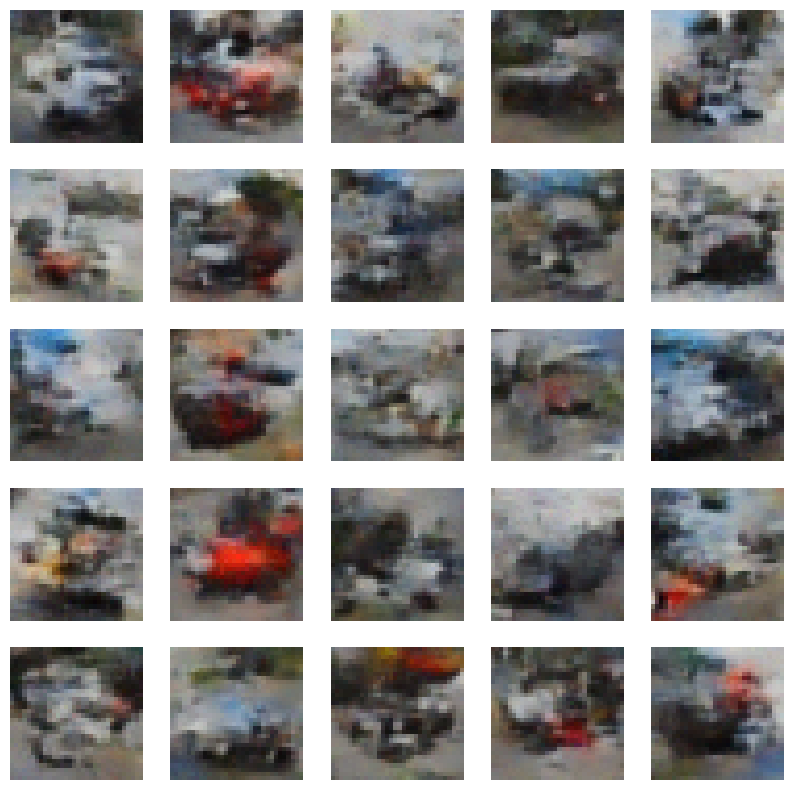

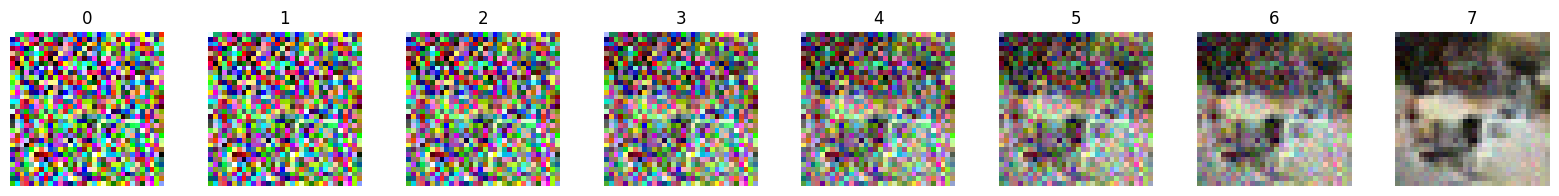

[26/200]	Average Train Loss: 0.02315538
[27/200]	Average Train Loss: 0.02311027
[27/200][19/203]	Loss: 0.02544468
[28/200]	Average Train Loss: 0.02327017
[29/200]	Average Train Loss: 0.02315834
[29/200][113/203]	Loss: 0.02265009
[30/200]	Average Train Loss: 0.02313162
[31/200]	Average Train Loss: 0.02311056
[32/200]	Average Train Loss: 0.02327842
[32/200][4/203]	Loss: 0.02406771
[33/200]	Average Train Loss: 0.02323919
[34/200]	Average Train Loss: 0.02305418
[34/200][98/203]	Loss: 0.02497793
[35/200]	Average Train Loss: 0.02322816
[36/200]	Average Train Loss: 0.02316311
[36/200][192/203]	Loss: 0.02338264
[37/200]	Average Train Loss: 0.02314983
[38/200]	Average Train Loss: 0.02310765
[39/200]	Average Train Loss: 0.02303905
[39/200][83/203]	Loss: 0.02388022
[40/200]	Average Train Loss: 0.02296192
[41/200]	Average Train Loss: 0.02306050
[41/200][177/203]	Loss: 0.02364051
[42/200]	Average Train Loss: 0.02317234
[43/200]	Average Train Loss: 0.02300837
[44/200]	Average Train Loss: 0.02303674


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

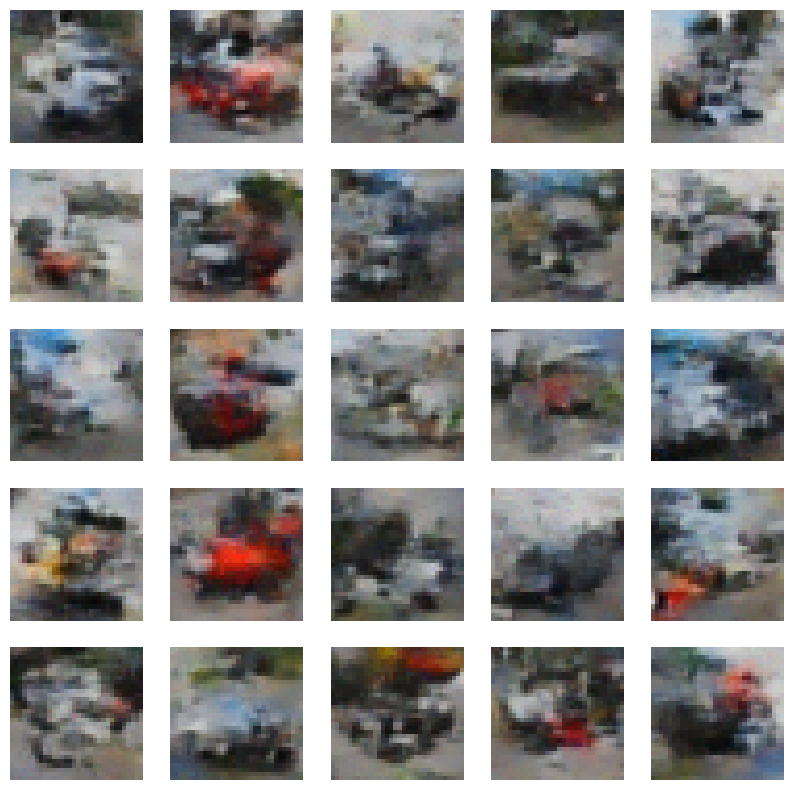

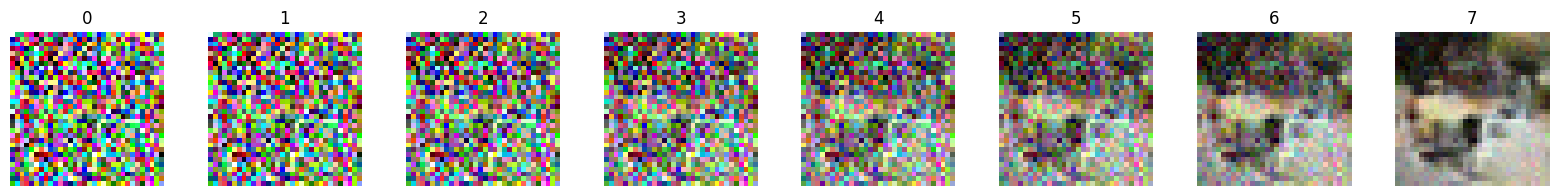

[51/200]	Average Train Loss: 0.02296204
[51/200][147/203]	Loss: 0.02247937
[52/200]	Average Train Loss: 0.02305674
[53/200]	Average Train Loss: 0.02300891
[54/200]	Average Train Loss: 0.02305857
[54/200][38/203]	Loss: 0.02039936
[55/200]	Average Train Loss: 0.02309318
[56/200]	Average Train Loss: 0.02309380
[56/200][132/203]	Loss: 0.02427708
[57/200]	Average Train Loss: 0.02306663
[58/200]	Average Train Loss: 0.02305660
[59/200]	Average Train Loss: 0.02297846
[59/200][23/203]	Loss: 0.02172818
[60/200]	Average Train Loss: 0.02302277
[61/200]	Average Train Loss: 0.02302315
[61/200][117/203]	Loss: 0.02544546
[62/200]	Average Train Loss: 0.02307291
[63/200]	Average Train Loss: 0.02316094
[64/200]	Average Train Loss: 0.02306815
[64/200][8/203]	Loss: 0.02272131
[65/200]	Average Train Loss: 0.02301581
[66/200]	Average Train Loss: 0.02301566
[66/200][102/203]	Loss: 0.02300677
[67/200]	Average Train Loss: 0.02295405
[68/200]	Average Train Loss: 0.02308367
[68/200][196/203]	Loss: 0.02332087
[69/

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

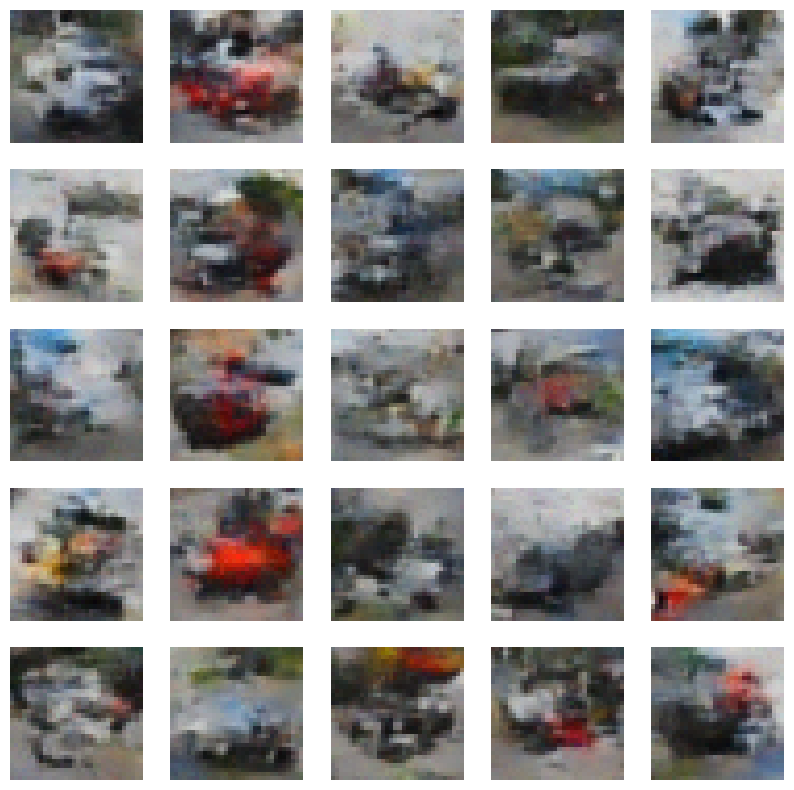

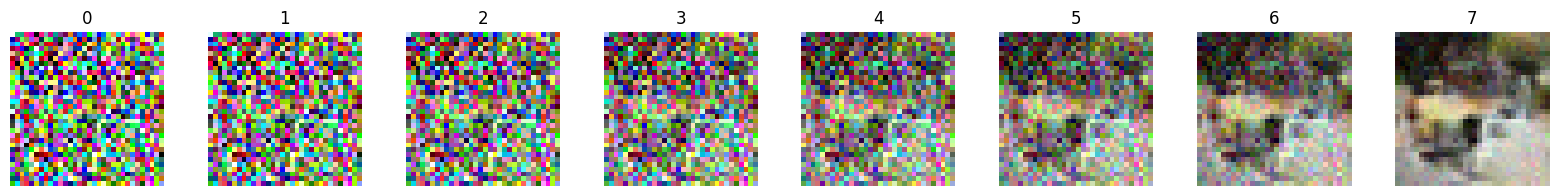

[76/200]	Average Train Loss: 0.02292519
[76/200][72/203]	Loss: 0.02267410
[77/200]	Average Train Loss: 0.02304372
[78/200]	Average Train Loss: 0.02298409
[78/200][166/203]	Loss: 0.02254512
[79/200]	Average Train Loss: 0.02298727
[80/200]	Average Train Loss: 0.02308063
[81/200]	Average Train Loss: 0.02305517
[81/200][57/203]	Loss: 0.02503228
[82/200]	Average Train Loss: 0.02299904
[83/200]	Average Train Loss: 0.02300120
[83/200][151/203]	Loss: 0.02553456
[84/200]	Average Train Loss: 0.02298173
[85/200]	Average Train Loss: 0.02302960
[86/200]	Average Train Loss: 0.02307755
[86/200][42/203]	Loss: 0.02370131
[87/200]	Average Train Loss: 0.02297283
[88/200]	Average Train Loss: 0.02299453
[88/200][136/203]	Loss: 0.02262951
[89/200]	Average Train Loss: 0.02299592
[90/200]	Average Train Loss: 0.02295656
[91/200]	Average Train Loss: 0.02302621
[91/200][27/203]	Loss: 0.02287005
[92/200]	Average Train Loss: 0.02305605
[93/200]	Average Train Loss: 0.02299007
[93/200][121/203]	Loss: 0.02230364
[94/

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

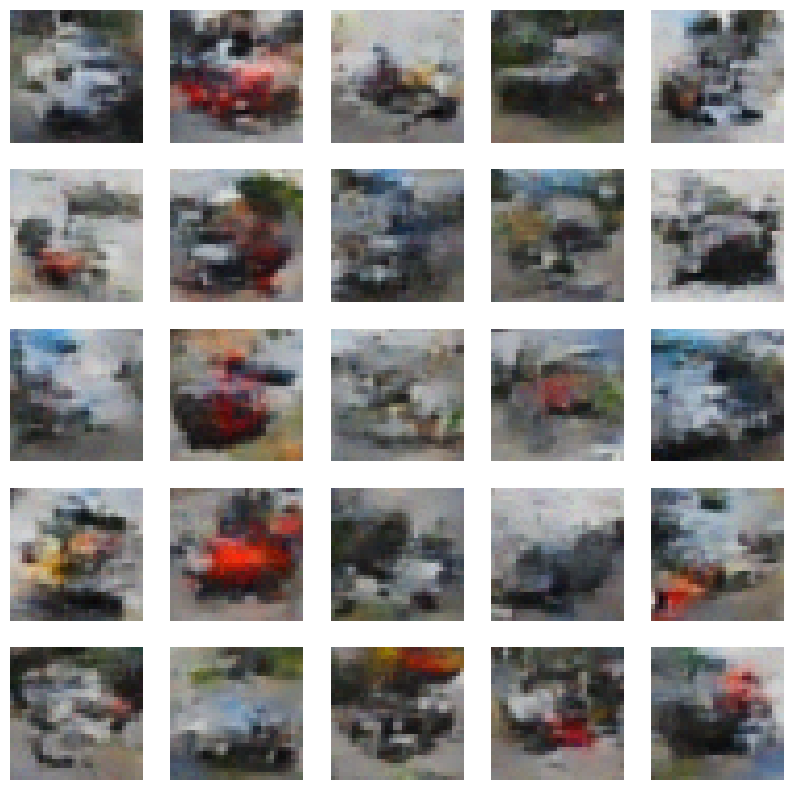

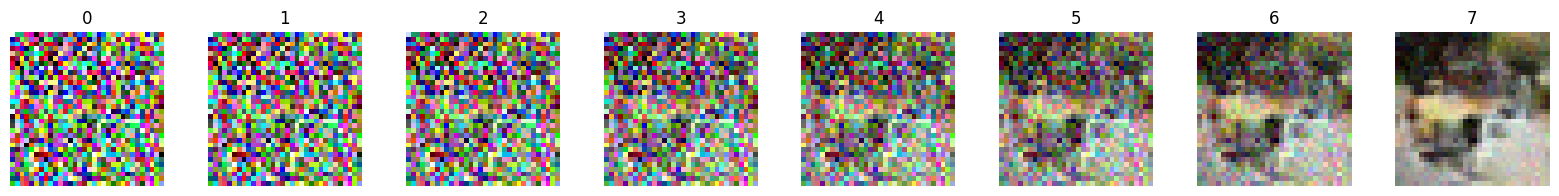

[100/200][200/203]	Loss: 0.02330194
[101/200]	Average Train Loss: 0.02310138
[102/200]	Average Train Loss: 0.02286382
[103/200]	Average Train Loss: 0.02298453
[103/200][91/203]	Loss: 0.02295296
[104/200]	Average Train Loss: 0.02305662
[105/200]	Average Train Loss: 0.02304117
[105/200][185/203]	Loss: 0.02316942
[106/200]	Average Train Loss: 0.02300955
[107/200]	Average Train Loss: 0.02290140
[108/200]	Average Train Loss: 0.02303713
[108/200][76/203]	Loss: 0.02276303
[109/200]	Average Train Loss: 0.02303220
[110/200]	Average Train Loss: 0.02297832
[110/200][170/203]	Loss: 0.02371543
[111/200]	Average Train Loss: 0.02299634
[112/200]	Average Train Loss: 0.02289041
[113/200]	Average Train Loss: 0.02294157
[113/200][61/203]	Loss: 0.02145126
[114/200]	Average Train Loss: 0.02292725
[115/200]	Average Train Loss: 0.02296451
[115/200][155/203]	Loss: 0.02191844
[116/200]	Average Train Loss: 0.02303640
[117/200]	Average Train Loss: 0.02298878
[118/200]	Average Train Loss: 0.02308016
[118/200][46/

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

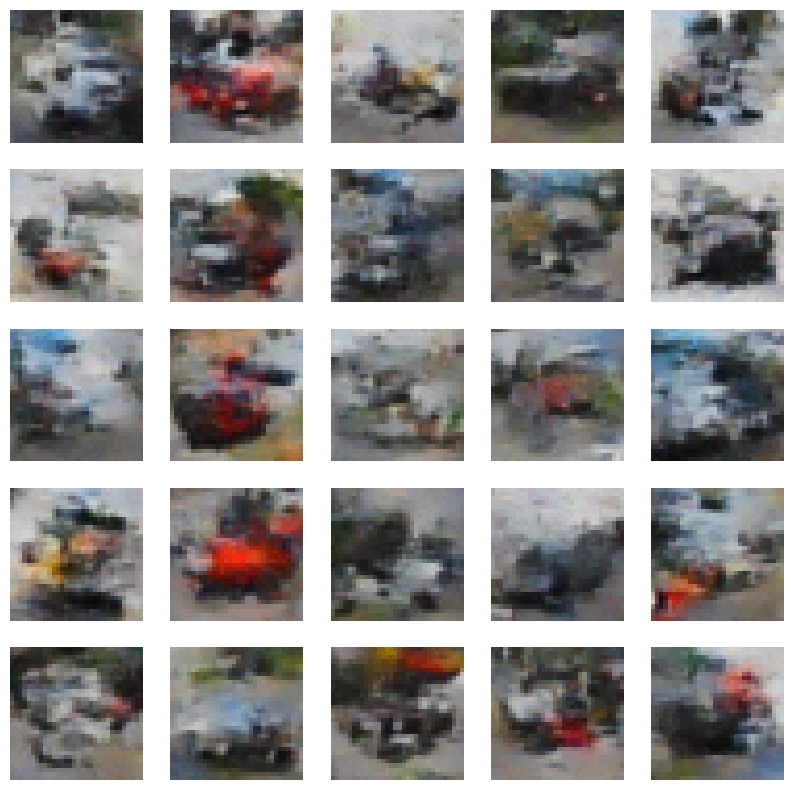

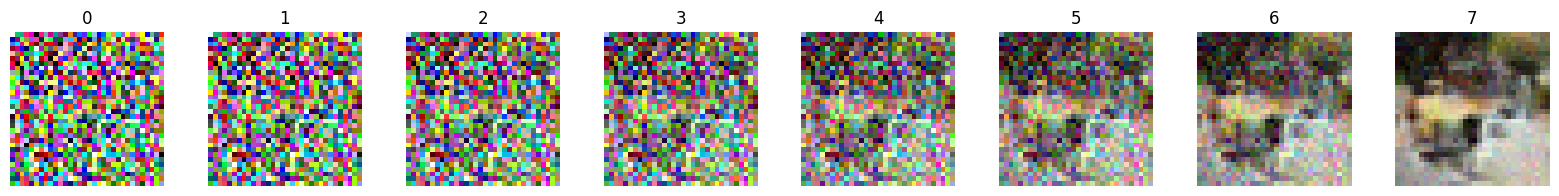

[125/200][125/203]	Loss: 0.02309847
[126/200]	Average Train Loss: 0.02302914
[127/200]	Average Train Loss: 0.02300999
[128/200]	Average Train Loss: 0.02296925
[128/200][16/203]	Loss: 0.02140730
[129/200]	Average Train Loss: 0.02286455
[130/200]	Average Train Loss: 0.02290703
[130/200][110/203]	Loss: 0.02345413
[131/200]	Average Train Loss: 0.02294499
[132/200]	Average Train Loss: 0.02297349
[133/200]	Average Train Loss: 0.02296519
[133/200][1/203]	Loss: 0.02291405
[134/200]	Average Train Loss: 0.02298364
[135/200]	Average Train Loss: 0.02294701
[135/200][95/203]	Loss: 0.02266322
[136/200]	Average Train Loss: 0.02292775
[137/200]	Average Train Loss: 0.02284093
[137/200][189/203]	Loss: 0.02217524
[138/200]	Average Train Loss: 0.02296946
[139/200]	Average Train Loss: 0.02295313
[140/200]	Average Train Loss: 0.02297946
[140/200][80/203]	Loss: 0.02316079
[141/200]	Average Train Loss: 0.02293189
[142/200]	Average Train Loss: 0.02290345
[142/200][174/203]	Loss: 0.02248453
[143/200]	Average Tr

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

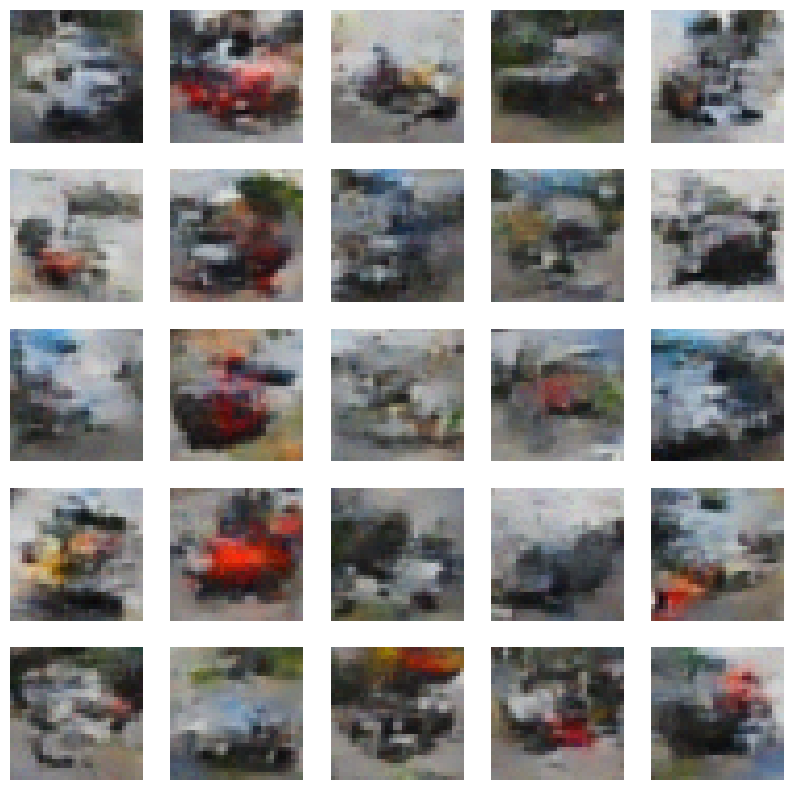

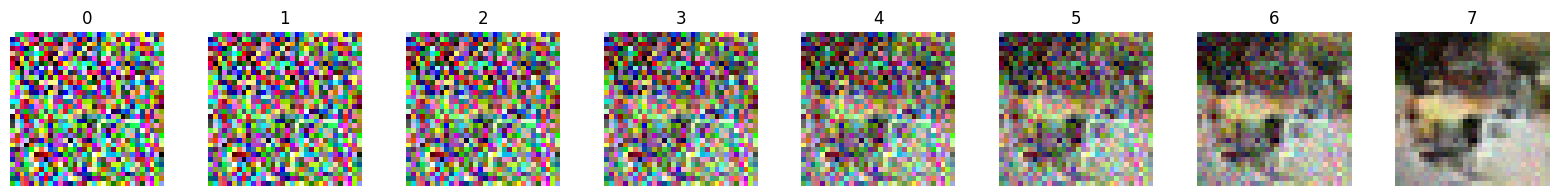

[150/200][50/203]	Loss: 0.02168642
[151/200]	Average Train Loss: 0.02287315
[152/200]	Average Train Loss: 0.02287619
[152/200][144/203]	Loss: 0.02305735
[153/200]	Average Train Loss: 0.02297636
[154/200]	Average Train Loss: 0.02295040
[155/200]	Average Train Loss: 0.02291483
[155/200][35/203]	Loss: 0.02492999
[156/200]	Average Train Loss: 0.02298317
[157/200]	Average Train Loss: 0.02295837
[157/200][129/203]	Loss: 0.02267449
[158/200]	Average Train Loss: 0.02298416
[159/200]	Average Train Loss: 0.02294700
[160/200]	Average Train Loss: 0.02293519
[160/200][20/203]	Loss: 0.02268916
[161/200]	Average Train Loss: 0.02289607
[162/200]	Average Train Loss: 0.02291182
[162/200][114/203]	Loss: 0.02215125
[163/200]	Average Train Loss: 0.02301894
[164/200]	Average Train Loss: 0.02285910
[165/200]	Average Train Loss: 0.02296526
[165/200][5/203]	Loss: 0.02231698
[166/200]	Average Train Loss: 0.02292335
[167/200]	Average Train Loss: 0.02299737
[167/200][99/203]	Loss: 0.02311636
[168/200]	Average Tra

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

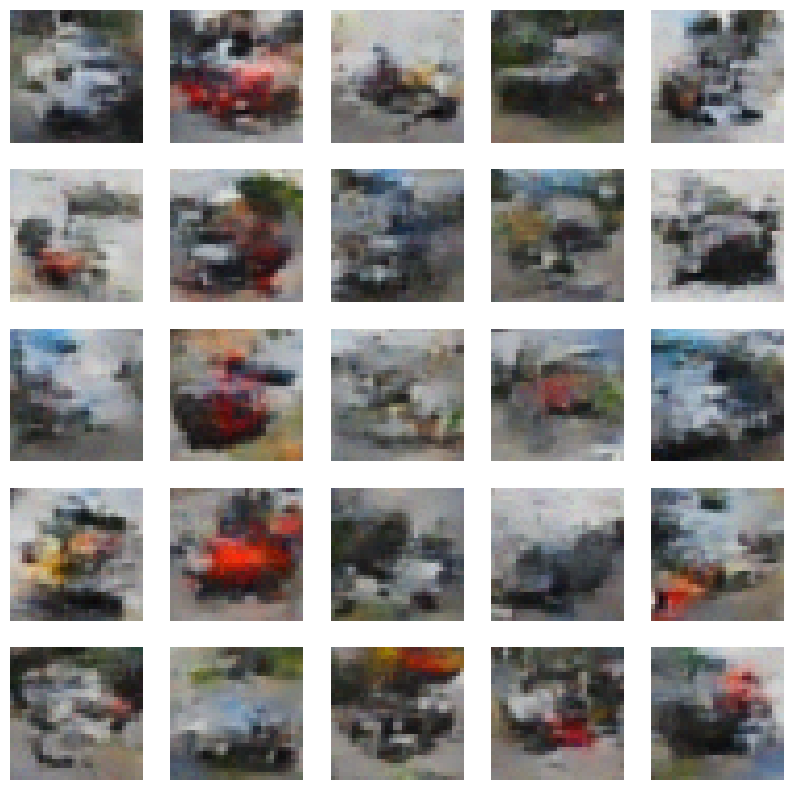

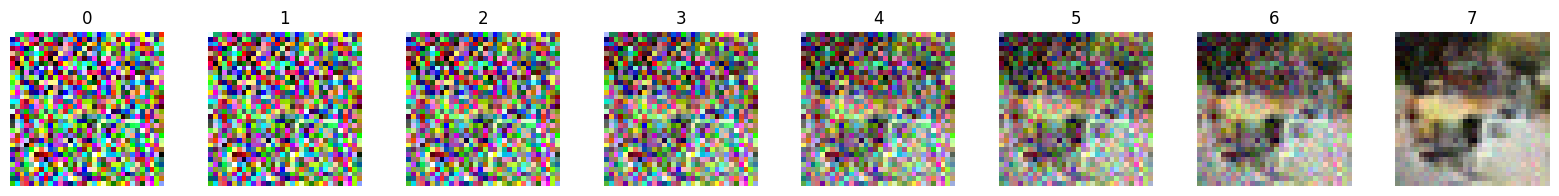

[176/200]	Average Train Loss: 0.02290763
[177/200]	Average Train Loss: 0.02293619
[177/200][69/203]	Loss: 0.02382538
[178/200]	Average Train Loss: 0.02286795
[179/200]	Average Train Loss: 0.02297735
[179/200][163/203]	Loss: 0.02276813
[180/200]	Average Train Loss: 0.02298161
[181/200]	Average Train Loss: 0.02300645
[182/200]	Average Train Loss: 0.02293695
[182/200][54/203]	Loss: 0.02238443
[183/200]	Average Train Loss: 0.02296218
[184/200]	Average Train Loss: 0.02295071
[184/200][148/203]	Loss: 0.02360377
[185/200]	Average Train Loss: 0.02296452
[186/200]	Average Train Loss: 0.02295949
[187/200]	Average Train Loss: 0.02298525
[187/200][39/203]	Loss: 0.02271880
[188/200]	Average Train Loss: 0.02294207
[189/200]	Average Train Loss: 0.02292621
[189/200][133/203]	Loss: 0.02230779
[190/200]	Average Train Loss: 0.02291679
[191/200]	Average Train Loss: 0.02301777
[192/200]	Average Train Loss: 0.02293931
[192/200][24/203]	Loss: 0.02187192
[193/200]	Average Train Loss: 0.02294690
[194/200]	Aver

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

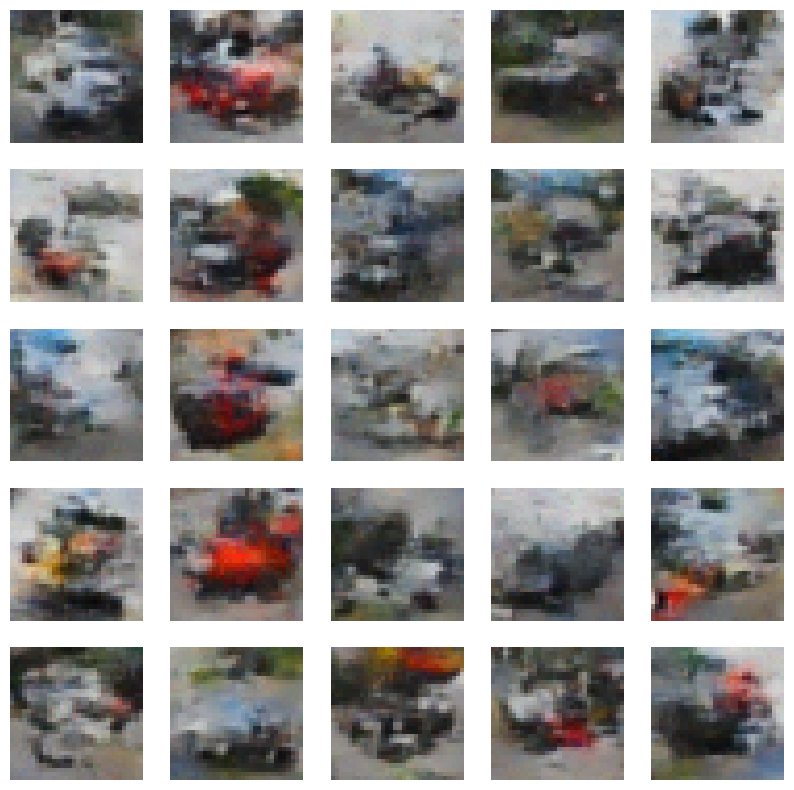

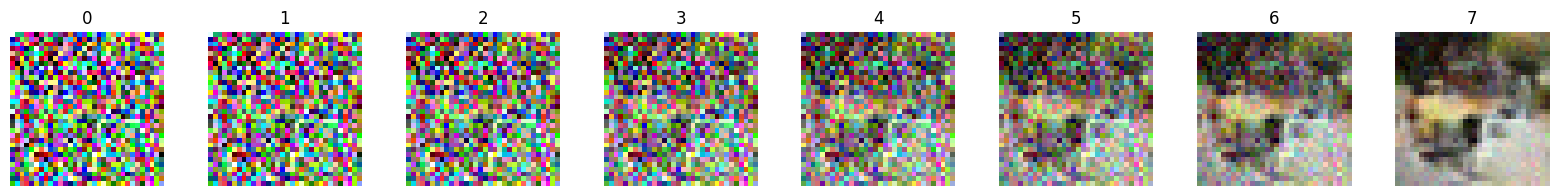

In [ ]:
# Variables for tracking the progress over epochs
img_list = []
train_losses = []
test_losses = []
fids = []

# Imagen de ruido fija para el entrenamiento.
x_fixed = torch.randn(25, 3, height, width).to(device)
x2_fixed = torch.randn(size=(1, 3, height, width), device=device)


# Number of trained batches
iters = 0

num_epochs = 200
epoca_fid = 25 # Calcula el FID cada 25 épocas

fixed_noise = torch.randn(batch_size, 3, height, width, device=device)  # Fixed noise to check the evolution of the model

# Usamos como función de pérdidas en entrenamiento el Error Cuadrático Medio
criterion = nn.L1Loss()

print("Starting Training Loop...")
for epoch in range(num_epochs):
    if((epoch + 1) % 25 == 0):
        for pg in model.opt.param_groups:
            pg['lr'] = max(0.0000001, pg['lr']*0.8)
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        model.train()  # Set the model to training mode

        train_batch = data[0]

        loss_item = train_one(train_batch, criterion)

        # Save Losses for plotting later
        train_losses.append(loss_item)

        # Output training stats
        if iters % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.8f'
                  % (epoch, num_epochs, i, len(train_loader), loss_item))

        iters += 1

    # Testing loop for each epoch - calculating test loss and FID
    model.eval()  # Set the model to evaluation mode
    if (epoch + 1) % epoca_fid == 0:  # Calcula el FID cada 25 épocas
        with torch.no_grad():
            test_loss_sum = 0.0
            test_fretchet_sum = 0.0
            for i, test_data in enumerate(test_loader, 0):
                test_batch = test_data[0]
                # Same steps as in training to prepare the inputs
                x_ts = generate_ts(len(test_batch))
                x_a, x_b = forward_noise(test_batch, x_ts)
                x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
                x_a = x_a.float().to(device)
                x_b = x_b.float().to(device)
                # Predict next step
                y_test_p = model(x_a, x_ts)
                # Calculate loss
                test_loss = criterion(y_test_p, x_b)
                test_loss_sum += test_loss.item()

                # Calculate Frechet Inception Distance
                generated_test = sample(torch.randn(batch_size, 3, height, width).to(device))

                test_fretchet = calculate_fid(test_batch, generated_test, False, batch_size)
                test_fretchet_sum += test_fretchet

            # Average test loss and FID over all test batches
            average_test_loss = test_loss_sum / len(test_loader)
            average_test_fretchet = test_fretchet_sum / len(test_loader)
            test_losses.append(average_test_loss)
            fids.append(average_test_fretchet)  # Almacenar el valor FID promedio para esta época

        # Imprimir los resultados
        print('[%d/%d]\tAverage Train Loss: %.8f\tAverage Test Loss: %.8f\tFID: %.8f'
              % (epoch + 1, num_epochs, np.mean(train_losses[-len(train_loader):]), average_test_loss, average_test_fretchet))
        predict_fixed(x_fixed)
        predict_step_fixed(x2_fixed)
        plt.show()

    else:
        # Solo imprime la pérdida de entrenamiento si no es una época de cálculo de FID
        print('[%d/%d]\tAverage Train Loss: %.8f'
              % (epoch + 1, num_epochs, np.mean(train_losses[-len(train_loader):])))

# Generate images with fixed noise to see the progression
    with torch.no_grad():
        # Necesitas definir un tensor para los pasos de tiempo, similar a como lo haces en el bucle de entrenamiento
        fixed_ts = generate_ts(batch_size)  # Asegúrate de que esta función genere los pasos de tiempo adecuados
        fixed_ts = torch.from_numpy(fixed_ts).view(-1, 1).float().to(device)

        # Ahora llama a model con ambos argumentos
        generated_display = model(fixed_noise, fixed_ts).detach().cpu()
    img_list.append(vutils.make_grid(generated_display, padding=2, normalize=True))


## **Resultados**

In [ ]:
fids

[275.7896240074131,
 273.896738473474,
 272.1242450799549,
 272.27003850373194,
 272.2202848752497,
 271.4978485633344,
 271.197742049523,
 271.2491796828351]

In [ ]:
train_losses

[0.6160422563552856,
 1.2083227634429932,
 0.8422157168388367,
 0.5352330803871155,
 0.4194808602333069,
 0.38880568742752075,
 0.3863336443901062,
 0.38994717597961426,
 0.46156537532806396,
 0.37507471442222595,
 0.32682427763938904,
 0.320585697889328,
 0.3538585603237152,
 0.30057933926582336,
 0.2665685713291168,
 0.31119638681411743,
 0.20559553802013397,
 0.2734326720237732,
 0.23675942420959473,
 0.23693430423736572,
 0.2254428118467331,
 0.2366243302822113,
 0.21160903573036194,
 0.18309319019317627,
 0.21329423785209656,
 0.1789933443069458,
 0.1745532751083374,
 0.16753940284252167,
 0.1826450079679489,
 0.14648215472698212,
 0.1633778214454651,
 0.152922123670578,
 0.13989189267158508,
 0.1319008767604828,
 0.11956895887851715,
 0.11872696876525879,
 0.12784774601459503,
 0.11455025523900986,
 0.11871466040611267,
 0.09682288765907288,
 0.11148848384618759,
 0.1034407913684845,
 0.09804169833660126,
 0.11879545450210571,
 0.10050934553146362,
 0.09310780465602875,
 0.096161

In [ ]:
torch.save(model, 'modelo_EAM_lr_200-pth')

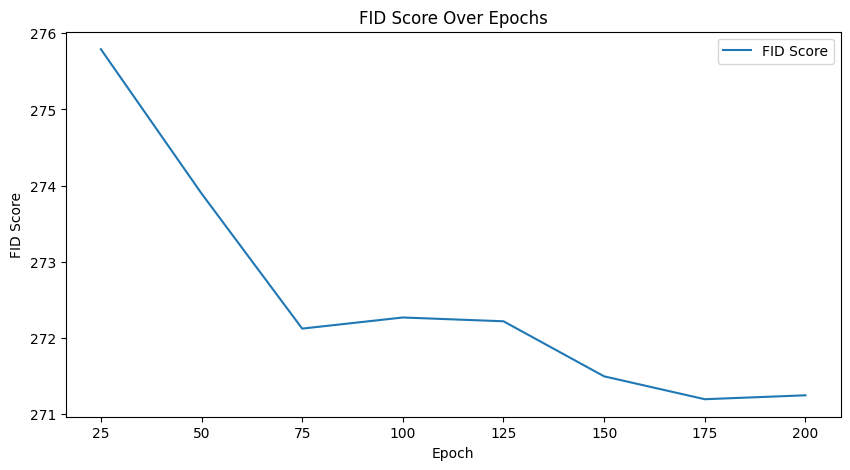

In [ ]:
plot_FID(fids, num_epochs, epoca_fid)

  0%|          | 0/16 [00:00<?, ?it/s]

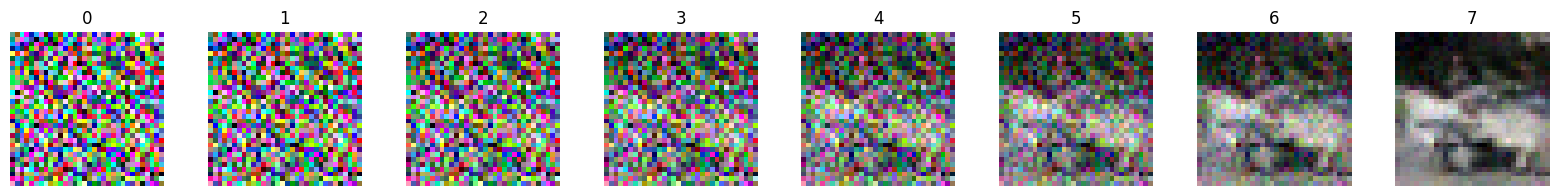

In [ ]:
predict_step()